# Image Segmentation Tutorial

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/georgia-tech-db/eva/blob/master/tutorials/07-object-segmentation-huggingface.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" /> Run on Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/georgia-tech-db/eva/blob/master/tutorials/07-object-segmentation-huggingface.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" /> View source on GitHub</a>
  </td>
  <td>
    <a target="_blank" href="https://raw.githubusercontent.com/georgia-tech-db/eva/master/tutorials/07-object-segmentation-huggingface.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" /> Download notebook</a>
  </td>
</table><br><br>

### Connect to EvaDB

In [1]:
%pip install --quiet "evadb[vision,notebook]"
import evadb
cursor = evadb.connect().cursor()
import warnings
warnings.filterwarnings("ignore")

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.6/137.6 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 76.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 76.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 89.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 631.1/631.1 kB 49.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 74.4

Downloading: "http://ml.cs.tsinghua.edu.cn/~chenxi/pytorch-models/mnist-b07bb66b.pth" to /root/.cache/torch/hub/checkpoints/mnist-b07bb66b.pth
100%|██████████| 1.03M/1.03M [00:01<00:00, 768kB/s]
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 189MB/s]


### Download the Videos

In [2]:
# # Getting the video files
!wget -nc "https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1" -O ua_detrac.mp4

--2023-10-11 05:32:13--  https://www.dropbox.com/s/k00wge9exwkfxz6/ua_detrac.mp4?raw=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.5.18, 2620:100:601d:18::a27d:512
Connecting to www.dropbox.com (www.dropbox.com)|162.125.5.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/raw/k00wge9exwkfxz6/ua_detrac.mp4 [following]
--2023-10-11 05:32:13--  https://www.dropbox.com/s/raw/k00wge9exwkfxz6/ua_detrac.mp4
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uced138b2fefa483907b6f48fdb9.dl.dropboxusercontent.com/cd/0/inline/CFb4ljcnRdGKLb_OHWKVSAJ7Z1S972p01nmTFtmkJQ1hwkBYmXWtFNIg5Oy3wXh3duAnILDOQyVbVXhvvRWNTGvGBaGFAmkOdJLDVC1inIWLgVE3oEvVbhHVPiM96uPfUM8eYzNm5U0NYM2DUzkGgeX5/file# [following]
--2023-10-11 05:32:13--  https://uced138b2fefa483907b6f48fdb9.dl.dropboxusercontent.com/cd/0/inline/CFb4ljcnRdGKLb_OHWKVSAJ7Z1S972p01nmTFtmkJQ1hwkBYmXWtFNIg5Oy3wXh3duAnILDOQyVbVXhvvRWNTGvGBaGFA

### Load sample video from DAVIS dataset for analysis

In [3]:
cursor.query('DROP TABLE IF EXISTS VideoForSegmentation;').df()
cursor.query('LOAD VIDEO "ua_detrac.mp4" INTO VideoForSegmentation;').df()

,0
0,Number of loaded VIDEO: 1


### Register Hugging Face Segmentation Model as an User-Defined Function (UDF) in EvaDB

In [4]:
### Using HuggingFace with EvaDB requires specifying the task
### The task here is 'image-segmentation'
### The model is 'facebook/detr-resnet-50-panoptic'
cursor.query("""
    CREATE FUNCTION IF NOT EXISTS HFSegmentation
    TYPE HuggingFace
    TASK 'image-segmentation'
    MODEL 'facebook/detr-resnet-50-panoptic';
""").df()

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.
`label_ids_to_fuse` unset. No instance will be fused.


,0
0,Function HFSegmentation added to the database.


### Run Image Segmentation on the video

In [5]:
response = cursor.query("""
    SELECT HFSegmentation(data)
    FROM VideoForSegmentation SAMPLE 5
    WHERE id < 20
""").df()
response

Some weights of the model checkpoint at facebook/detr-resnet-50-panoptic were not used when initializing DetrForSegmentation: ['detr.model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer1.0.downsample.1.num_batches_tracked', 'detr.model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing DetrForSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DetrForSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Could not find image processor class in the image processor conf

,score,label,mask
0,"[0.906596, 0.989519, 0.960914, 0.923786, 0.960...","[motorcycle, motorcycle, person, car, car, per...",[<PIL.Image.Image image mode=L size=960x540 at...
1,"[0.985118, 0.963139, 0.963819, 0.96094, 0.9268...","[motorcycle, person, car, car, person, bridge,...",[<PIL.Image.Image image mode=L size=960x540 at...
2,"[0.989573, 0.900049, 0.966254, 0.96056, 0.9388...","[motorcycle, person, person, car, car, car, pe...",[<PIL.Image.Image image mode=L size=960x540 at...
3,"[0.913261, 0.949733, 0.943764, 0.98639, 0.9744...","[truck, person, car, car, car, car, car, perso...",[<PIL.Image.Image image mode=L size=960x540 at...


### Visualizing output of the Image Segmenter on the video

In [6]:
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import cv2

def get_color_mapping(all_labels):
    unique_labels = set(label for labels in all_labels for label in labels)
    num_colors = len(unique_labels)
    colormap = plt.colormaps["tab20"]
    colors = [colormap(i % 20)[:3] for i in range(num_colors)]
    colors = [tuple(int(c * 255) for c in color) for color in colors]
    color_mapping = {label: color for label, color in zip(unique_labels, colors)}
    return  color_mapping

def annotate_single_frame(frame, segments, labels, color_mapping):
    overlay = np.zeros_like(frame)

    # Overlay segments
    for mask, label in zip(segments, labels):
        mask_np = np.array(mask).astype(bool)
        overlay[mask_np] = color_mapping[label]

    # Combine original frame with overlay
    new_frame = Image.blend(
        Image.fromarray(frame.astype(np.uint8)),
        Image.fromarray(overlay.astype(np.uint8)),
        alpha=0.5,
    )

    return new_frame

def annotate_video(segmentations, input_video_path, output_video_path, model_name = 'hfsegmentation'):
    all_segments = segmentations[f'mask']
    all_labels = segmentations[f'label']


    color_mapping = get_color_mapping(all_labels)

    vcap = cv2.VideoCapture(input_video_path)
    width = int(vcap.get(3))
    height = int(vcap.get(4))
    fps = vcap.get(5)
    fourcc = cv2.VideoWriter_fourcc('m', 'p', '4', 'v') #codec
    video=cv2.VideoWriter(output_video_path, fourcc, fps, (width,height))

    frame_id = 0
    ret, frame = vcap.read()
    while ret and frame_id < len(all_segments):
        segments = all_segments[frame_id]
        labels = all_labels[frame_id]
        new_frame = annotate_single_frame(frame, segments, labels, color_mapping)
        video.write(np.array(new_frame))
        if frame_id % 5 == 0:
            legend_patches = [mpatches.Patch(color=np.array(color_mapping[label])/255, label=label) for label in set(labels)]
            plt.imshow(new_frame)
            plt.legend(handles=legend_patches, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
            plt.axis('off')
            plt.tight_layout()
            plt.show()


        frame_id += 1
        ret, frame = vcap.read()

    video.release()
    vcap.release()

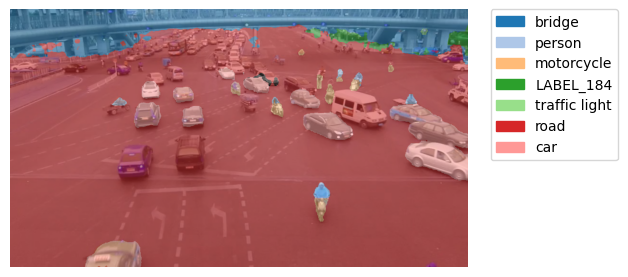

Video(value=b'\x00\x00\x00\x1cftypisom\x00\x00\x02\x00isomiso2mp41\x00\x00\x00\x08free\x00\x01\xb5C...')

In [7]:
from ipywidgets import Video
input_path = 'ua_detrac.mp4'
output_path = 'video.mp4'

annotate_video(response, input_path, output_path)
Video.from_file(output_path)

### Drop functions

In [8]:
cursor.query("DROP FUNCTION HFSegmentation").df()

,0
0,Function HFSegmentation successfully dropped
